In [3]:
# Some code is shamelessly copied from Learning Blogs
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from pylab import rcParams
import math
import zipfile
from datetime import datetime
from dateutil import parser
import datetime
import random

pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 15, 5


def parseDate(d):
    try:
        return parser.parse(d)        
    except:
        return None

def maxD(v):
    dt1 = parseDate(v[0])
    dt2 = parseDate(v[1])
    if dt1 is not None and dt2 is not None:
        return max(dt1, dt2)
    elif dt1 is not None:
        return dt1
    else:
        return dt2
    
def addDelta(v):
    delta = datetime.timedelta(0,random.randint(1, 15), random.randint(1, 1001))
    dt = parseDate(str(v[0]))
    if dt is not None:
        return dt+delta
    else:
        return dt
    

    
def num(s):
    try:
        return int(s[0])
    except ValueError:
        return float(s[0])
    except ValueError:
        return None

def differ(v):
    d1 = num(v[0])
    d2 = num(v[1])
    if d1 is not None and d2 is not None and abs(d1-d2)<=10:
        return False
    else:
        return True
    
def pererr(err, avg):
    return (err/avg)*100

def mean(l):
    return reduce(lambda x, y: x + y, l) / len(l)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


# invert differenced value
def inverse_difference(history, pred, interval=1):
    return pred + history[-interval]

    
def predict(coef, history):
    pred = 0.0
    for i in range(1, len(coef)+1):
        pred += coef[i-1] * history[-i]
    return pred    
 

In [4]:
zf = zipfile.ZipFile('data/order-reports_09_10_2017_19_45.csv.zip') 
kp = pd.read_csv(zf.open('order-reports_09_10_2017_19_45.csv'), header=0)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (31,33,68,69,92,94,99,106,110,114,119,124,129,130,132,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
kpi=kp.iloc[:, 
          [0, 2, 6, 7, 8, 9, 10, 11, 14, 20, 22, 
           37, 38, 39, 75, 41, 93, 95]]
kpi.count()


Id                     12695
Customer Name          12695
From City              12695
To City                12695
Distance               12677
From Sublocation       12695
To Sublocation         12695
Order Value             9937
Used truck Type         9933
Warehouse Start Loc    12695
Warehouse End Loc      12695
Sector Name            12695
Tonnage                10573
Per Ton Rate            5599
Product Name           12695
Freight Amount          9912
Order Accepted          8743
Order Blocked           2905
dtype: int64

In [6]:
# Picking earliest of Order Accepted or Order Blocked date as Order Date
kpi['date']=kpi[['Order Accepted', 'Order Blocked']].apply(maxD, axis=1)
#kpi.drop(['Order Accepted', 'Order Blocked'], axis=1, inplace=True)
kpi.count()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Id                     12695
Customer Name          12695
From City              12695
To City                12695
Distance               12677
From Sublocation       12695
To Sublocation         12695
Order Value             9937
Used truck Type         9933
Warehouse Start Loc    12695
Warehouse End Loc      12695
Sector Name            12695
Tonnage                10573
Per Ton Rate            5599
Product Name           12695
Freight Amount          9912
Order Accepted          8743
Order Blocked           2905
date                   11590
dtype: int64

In [7]:
## Checking how much bad Values/Rows we have
kpi[(pd.isnull(kpi['Freight Amount'])==False) & (pd.isnull(kpi['Order Value'])==False)].count()

Id                     9912
Customer Name          9912
From City              9912
To City                9912
Distance               9899
From Sublocation       9912
To Sublocation         9912
Order Value            9912
Used truck Type        9912
Warehouse Start Loc    9912
Warehouse End Loc      9912
Sector Name            9912
Tonnage                9066
Per Ton Rate           5599
Product Name           9912
Freight Amount         9912
Order Accepted         7163
Order Blocked          2801
date                   9912
dtype: int64

In [8]:
# droping all rows where we don't know about date (i.e date is null)
kpi = kpi[pd.isnull(kpi['date'])==False]
kpi.count()

Id                     11590
Customer Name          11590
From City              11590
To City                11590
Distance               11576
From Sublocation       11590
To Sublocation         11590
Order Value             9937
Used truck Type         9933
Warehouse Start Loc    11590
Warehouse End Loc      11590
Sector Name            11590
Tonnage                10572
Per Ton Rate            5599
Product Name           11590
Freight Amount          9912
Order Accepted          8743
Order Blocked           2905
date                   11590
dtype: int64

In [9]:
# calculating per unit km per ton price for the lane
kpi['ptr'] = (kpi['Freight Amount']/(kpi['Tonnage']*(kpi['Distance']/1000)))


In [10]:
# check whether we have duplicate dates
kpi['date'].unique().size

10370

In [11]:
kpi[kpi.date.duplicated()]


,Id,Customer Name,From City,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Order Accepted,Order Blocked,date,ptr
174,348671,Vertigo,Mundra,Jammu,1557051.0,Mundra,Bari Brahmana,NaN,NaN,Mundra-Mundra,Jammu-Bari Brahmana,Mundra - Kandla cluster,29.00,NaN,Bitumen,NaN,16-Aug-2017 08:52 PM,NaN,2017-08-16 20:52:00,NaN
344,365528,Raghav Goel,Mundra,Muzaffarnagar,1282781.0,Mundra,Muzaffarnagar,90246.0,30 MT,Mundra-Mundra,Muzaffarnagar-Muzaffarnagar,Mundra - Kandla cluster,34.71,2600.0,Coal,90246.00,10-Sep-2017 11:46 AM,NaN,2017-09-10 11:46:00,2.026846
424,339086,Raghav Goel,Mundra,Muzaffarnagar,1276348.0,Mundra,Muzaffarnagar,NaN,NaN,Mundra-Mundra,Muzaffarnagar-Muzaffarnagar,Mundra - Kandla cluster,35.00,NaN,Coal,NaN,01-Aug-2017 11:02 AM,NaN,2017-08-01 11:02:00,NaN
516,190568,Gandhidham Customers,Mundra,New Delhi,1191667.0,Mundra,Narela,87500.0,34T,mundra,Narela,Mundra - Kandla cluster,24.42,NaN,Coal,87500.00,NaN,13-Dec-2016 12:59 PM,2016-12-13 12:59:00,3.006820
595,352760,Sharp Corp,Mundra,New Delhi,1167045.0,Mundra,Baljit Vihar,NaN,NaN,Mundra port,New Delhi-Baljit Vihar,Mundra - Kandla cluster,36.00,NaN,Chana,NaN,22-Aug-2017 06:19 PM,NaN,2017-08-22 18:19:00,NaN
600,357981,Vipin Jain,Mundra,Muzaffarnagar,1276339.0,Mundra,Muzaffarnagar,NaN,NaN,Mundra-Mundra,Muzaffarnagar-Muzaffarnagar,Mundra - Kandla cluster,35.00,NaN,Coal,NaN,30-Aug-2017 10:21 AM,NaN,2017-08-30 10:21:00,NaN
603,366170,Sarthak,Mundra,Jaipur,897065.0,Mundra,Jaipur,NaN,NaN,Mundra-Mundra,Jaipur-Jaipur,Mundra - Kandla cluster,36.00,NaN,Yellow Peas,NaN,11-Sep-2017 02:26 PM,NaN,2017-09-11 14:26:00,NaN
659,339815,Vertigo,Mundra,Tijara,1086006.0,Mundra,Bhiwadi,69300.0,30 MT,Mundra-Mundra,Tijara-Bhiwadi,Mundra - Kandla cluster,35.00,1980.0,Coal,69300.00,02-Aug-2017 03:20 PM,NaN,2017-08-02 15:20:00,1.823194
691,361177,konkan agro,Mundra,Pathankot,1469342.0,Mundra,Pathankot,72300.0,30 MT,Manjeet,Pathankot,Mundra - Kandla cluster,28.92,2500.0,Coal,72300.00,04-Sep-2017 10:29 AM,NaN,2017-09-04 10:29:00,1.701442
727,357004,Sachin Vikash Pulses,Mundra,New Delhi,1177921.0,Mundra,Narela,68232.0,27T/28T,Mundra-Mundra,New Delhi-Narela,Mundra - Kandla cluster,28.43,2400.0,Coal,68232.00,29-Aug-2017 11:02 AM,NaN,2017-08-29 11:02:00,2.037488


In [12]:
# how many duplicates we have
kpi[kpi.date.duplicated()].count()

Id                     1220
Customer Name          1220
From City              1220
To City                1220
Distance               1220
From Sublocation       1220
To Sublocation         1220
Order Value            1013
Used truck Type        1013
Warehouse Start Loc    1220
Warehouse End Loc      1220
Sector Name            1220
Tonnage                1166
Per Ton Rate            846
Product Name           1220
Freight Amount         1010
Order Accepted         1171
Order Blocked            51
date                   1220
ptr                     974
dtype: int64

In [13]:
# Lets try to make d as unique as possible by adding some secs, ms
kpi['d'] = kpi[['date']].apply(addDelta, axis=1)

In [14]:
kpi['d'].unique().size
# should come around the count of rows we have

11590

In [15]:
# Lets Group By by ('From City', 'From Sublocation', 'To City', 'To Sublocation', 'Used truck Type', 'Product Name')
kpi.groupby(['From City', 'From Sublocation', 'To City', 'To Sublocation', 'Used truck Type', 'Product Name']).count().nlargest(10, 'Id')

Id  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name          
Anjar     Kandla           Pune          Kurkumbh       21T/20T         Agriculture     419   
                           Pathankot     Pathankot      30 MT           Coal            364   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods  284   
Mundra    Mundra           New Delhi     Block A1       27T/28T         Agriculture     204   
Anjar     Kandla           Muzaffarnagar Muzaffarnagar  34T             Coal            203   
                           Pune          Kasba Peth     21T/20T         Agriculture     194   
          Gandhidham       Panipat       Panipat        27T/28T         Textiles        179   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Oil             176   
          Kandla           Ahmedabad     Narolgam       30 MT           Coal            171   
                           Vallabhnagar  Dabok          30 MT           Coal            154   

                                                                                        Customer Name  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name                    
Anjar     Kandla           Pune          Kurkumbh       21T/20T         Agriculture               419   
                           Pathankot     Pathankot      30 MT           Coal                      364   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods            284   
Mundra    Mundra           New Delhi     Block A1       27T/28T         Agriculture               204   
Anjar     Kandla           Muzaffarnagar Muzaffarnagar  34T             Coal                      203   
                           Pune          Kasba Peth     21T/20T         Agriculture               194   
          Gandhidham       Panipat       Panipat        27T/28T         Textiles                  179   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Oil                       176   
          Kandla           Ahmedabad     Narolgam       30 MT           Coal                      171   
                           Vallabhnagar  Dabok          30 MT           Coal                      154   

                                                                                        Distance  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name               
Anjar     Kandla           Pune          Kurkumbh       21T/20T         Agriculture          419   
                           Pathankot     Pathankot      30 MT           Coal                 364   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods       284   
Mundra    Mundra           New Delhi     Block A1       27T/28T         Agriculture          204   
Anjar     Kandla           Muzaffarnagar Muzaffarnagar  34T             Coal                 203   
                           Pune          Kasba Peth     21T/20T         Agriculture          192   
          Gandhidham       Panipat       Panipat        27T/28T         Textiles             179   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Oil                  176   
          Kandla           Ahmedabad     Narolgam       30 MT           Coal                 171   
                           Vallabhnagar  Dabok          30 MT           Coal                 154   

                                                                                        Order Value  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name                  
Anjar     Kandla           Pune          Kurkumbh       21T/20T         Agriculture             418   
                           Pathankot     Pathankot      30 MT           Coal                    364   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Pa

In [16]:
kpi.groupby(['From City', 'Used truck Type']).count().nlargest(10, 'Id')

Id  Customer Name  To City  Distance  \
From City Used truck Type                                           
Anjar     27T/28T          3524           3524     3524      3522   
          21T/20T          1861           1861     1861      1855   
          30 MT            1754           1754     1754      1753   
          34T               783            783      783       783   
Mundra    27T/28T           532            532      532       532   
          34T               437            437      437       437   
          30 MT             264            264      264       264   
Anjar     25T/24T           217            217      217       216   
          16T/15T           215            215      215       213   
Mundra    16T/15T           155            155      155       154   

                           From Sublocation  To Sublocation  Order Value  \
From City Used truck Type                                                  
Anjar     27T/28T                      3524            3524         3517   
          21T/20T                      1861            1861         1860   
          30 MT                        1754            1754         1754   
          34T                           783             783          783   
Mundra    27T/28T                       532             532          530   
          34T                           437             437          434   
          30 MT                         264             264          264   
Anjar     25T/24T                       217             217          217   
          16T/15T                       215             215          215   
Mundra    16T/15T                       155             155          155   

                           Warehouse Start Loc  Warehouse End Loc  \
From City Used truck Type                                           
Anjar     27T/28T                         3524               3524   
          21T/20T                         1861               1861   
          30 MT                           1754               1754   
          34T                              783                783   
Mundra    27T/28T                          532                532   
          34T                              437                437   
          30 MT                            264                264   
Anjar     25T/24T                          217                217   
          16T/15T                          215                215   
Mundra    16T/15T                          155                155   

                           Sector Name  Tonnage  Per Ton Rate  Product Name  \
From City Used truck Type                                                     
Anjar     27T/28T                 3524     2928          2086          3524   
          21T/20T                 1861     1671           242          1861   
          30 MT                   1754     1753          1749          1754   
          34T                      783      743           663           783   
Mundra    27T/28T                  532      529           140           532   
          34T                      437      433           217           437   
          30 MT                    264      264           260           264   
Anjar     25T/24T                  217      186            75           217   
          16T/15T                  215      213             8           215   
Mundra    16T/15T                  155      155             0           155   

                           Freight Amount  Order Accepted  Order Blocked  \
From City Used truck Type                                                  
Anjar     27T/28T                    3516            2406           1133   
          21T/20T                    1854            1147            724   
          30 MT                      1754            1748             20   
          34T                         783             664            124   
Mundra    27T/28T                     530            

In [17]:
kpi.groupby(['From City', 'Product Name']).count().nlargest(10, 'Id')

Id  Customer Name  To City  Distance  \
From City Product Name                                             
Anjar     Coal            3130           3130     3130      3128   
          Oil             2338           2338     2338      2338   
          Agriculture     2026           2026     2026      2017   
          Packaged Foods   904            904      904       904   
Mundra    Coal             742            742      742       742   
Anjar     Sugar            412            412      412       412   
Mundra    Agriculture      404            404      404       404   
Anjar     Textiles         245            245      245       245   
          Non-metals       219            219      219       219   
Mundra    Yellow Peas      218            218      218       218   

                          From Sublocation  To Sublocation  Order Value  \
From City Product Name                                                    
Anjar     Coal                        3130            3130         2468   
          Oil                         2338            2338         1912   
          Agriculture                 2026            2026         1964   
          Packaged Foods               904             904          882   
Mundra    Coal                         742             742          621   
Anjar     Sugar                        412             412          378   
Mundra    Agriculture                  404             404          400   
Anjar     Textiles                     245             245          191   
          Non-metals                   219             219          210   
Mundra    Yellow Peas                  218             218          164   

                          Used truck Type  Warehouse Start Loc  \
From City Product Name                                           
Anjar     Coal                       2468                 3130   
          Oil                        1912                 2338   
          Agriculture                1954                 2026   
          Packaged Foods              879                  904   
Mundra    Coal                        624                  742   
Anjar     Sugar                       378                  412   
Mundra    Agriculture                 402                  404   
Anjar     Textiles                    197                  245   
          Non-metals                  209                  219   
Mundra    Yellow Peas                 164                  218   

                          Warehouse End Loc  Sector Name  Tonnage  \
From City Product Name                                              
Anjar     Coal                         3130         3130     3120   
          Oil                          2338         2338     2338   
          Agriculture                  2026         2026     1947   
          Packaged Foods                904          904       33   
Mundra    Coal                          742          742      732   
Anjar     Sugar                         412          412      401   
Mundra    Agriculture                   404          404      400   
Anjar     Textiles                      245          245      236   
          Non-metals                    219          219      210   
Mundra    Yellow Peas                   218          218      218   

                          Per Ton Rate  Freight Amount  Order Accepted  \
From City Product Name                                                   
Anjar     Coal                    2263            2468            2912   
          Oil                     1912            1912            2338   
          Agriculture                5            1949             992   
          Packaged Foods             2             874             311   
Mundra    Coal                     391             621             503   
Anjar     Sugar                    266             378             289   
Mundra    Agriculture                1             400               0   
Anjar     Textiles    

In [18]:
# Group by From City
kpi.groupby(['From City']).count().nlargest(10, 'Id')

,Id,Customer Name,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Order Accepted,Order Blocked,date,ptr,d
From City,,,,,,,,,,,,,,,,,,,,
Anjar,9910,9910,9910,9897,9910,9910,8492,8483,9910,9910,9910,8910,4952,9910,8467,7733,2229,9910,7611,9910
Mundra,1680,1680,1680,1679,1680,1680,1445,1450,1680,1680,1680,1662,647,1680,1445,1010,676,1680,1442,1680


In [19]:
# Let's work out on Top 3 lane based on count of orders
s1 = kpi[(kpi['From Sublocation']=='Tuna') & (kpi['To Sublocation']=='Pathankot') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
s2 = kpi[(kpi['From Sublocation']=='Kandla') & (kpi['To Sublocation']=='Dabok') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
s3 = kpi[(kpi['From Sublocation']=='Kandla') & (kpi['To Sublocation']=='Dholka') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
# We are droping Anjar-Agra as there is no info about Tonnage, we will see it later on
s4 = kpi[(kpi['From Sublocation']=='Lilashah Nagar') & (kpi['To Sublocation']=='Dholpur House') & (kpi['Used truck Type']=='27T/28T') & (kpi['Product Name']=='Packaged Foods')]

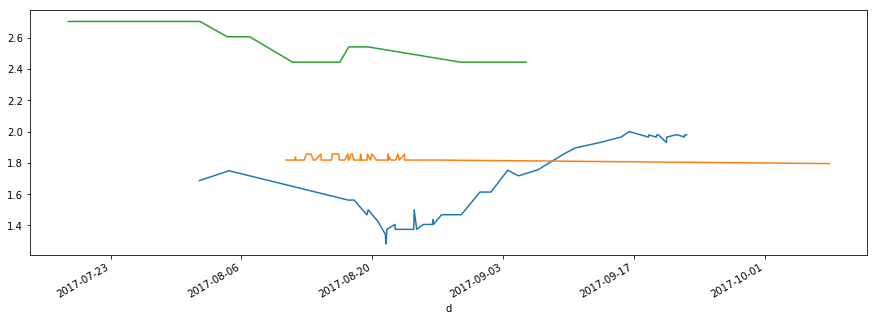

In [20]:
# per km per ton price for the shorter lane is higher than longer lanes 
# that may be inferred due to fixed cost of driver
s = [s1, s2, s3]
sp = [Series(x['ptr'].values, index=x['d']) for x in s]
[x.plot() for x in sp]



In [21]:
s = [s1, s2, s3, s4]
s = [Series(x['Per Ton Rate'].values, index=x['d']) for x in s]


In [26]:
s

[d
 2017-08-27 10:04:02.000064    2350.0
 2017-08-24 10:55:07.000542    2250.0
 2017-08-24 10:56:05.000907    2250.0
 2017-08-31 12:38:15.000474    2300.0
 2017-08-31 12:35:11.000244    2300.0
 2017-08-20 10:41:07.000487    2300.0
 2017-08-21 11:35:03.000347    2050.0
 2017-08-22 11:02:03.000026    2200.0
 2017-08-22 17:59:08.000067    2200.0
 2017-08-17 10:38:05.000376    2500.0
 2017-09-06 14:09:11.000374    2500.0
 2017-08-29 10:00:15.000486    2350.0
 2017-09-03 11:59:06.000589    2500.0
 2017-08-19 09:55:02.000888    2350.0
 2017-09-15 14:26:15.000293    2800.0
 2017-09-04 17:50:15.000839    2450.0
 2017-08-26 10:34:02.000838    2250.0
 2017-08-26 10:35:09.000654    2250.0
 2017-09-09 14:32:03.000925    2650.0
 2017-08-24 10:25:01.000032    2200.0
 2017-09-04 17:32:11.000737    2450.0
 2017-08-28 17:08:02.000411    2350.0
 2017-08-19 10:32:04.000315    2350.0
 2017-08-20 10:41:03.000273    2300.0
 2017-08-21 10:25:01.000671    2100.0
 2017-08-22 10:20:13.000349    2250.0
 2017-08-

In [23]:
# run RF takes a pandas.Series with dateIndex and T as number of Test Points
def runRF(series, T, W):
    X = series.values
    size = len(X) - T

    # move each window by 1 data point
    # keep last chunk for prediction
    NWs = len(X)-W-T-1 

    # Features should have dimensions (NWs x WSize)
    # Labels should have dimensions (NWs)
    feat = np.zeros( [NWs, W] ) - 9999999. # blank array to fill
    labl = np.zeros( [NWs] ) - 99999.
    sh = np.shape(feat)
    
    # Now fill the feature and label arrays with differencing
    for i in range(int(NWs)):
        feat[i,:] = X[i:i+W] - X[i+W]
        labl[i] = X[i+W+1] - X[i+W]
        
    
    # Now make test features and test labels to compare with
    test_feat = np.zeros( [T, W] )
    test_labl = np.zeros( [T] )

    for i in range(T):
        test_feat[i,:] = X[i+NWs:i+NWs+W] - X[i+NWs+W]
        test_labl[i] = X[i+NWs+W+1] - X[i+NWs+W]
    
    # Code taken from Josh Bloom's lecture
    from sklearn.ensemble import RandomForestRegressor
    rfRegress = RandomForestRegressor(n_estimators=500, 
                                criterion='mae', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                max_features='auto', max_leaf_nodes=None, 
                                bootstrap=True, oob_score=False, n_jobs=1, 
                                random_state=None, verbose=0)
    rfRegress.fit(feat, labl)
    pred = rfRegress.predict(test_feat)
    #plt.plot(test_labl, "b-")
    #plt.plot(pred,'go')

    
    #Series(pred, series.index[size:]).plot(color="green", label="Prediction_DIFF")
    #Series(test_labl, series.index[size:]).plot(color="blue", label="Expected_DIFF_Smoothed") 
    
    
    ### Lets get some numbers
    test_labl_act = np.zeros( [T] )
    pred_act = np.zeros( [T] )
    errs = []
    for i in range(T):
        test_labl_act[i] = test_labl[i] + X[i+NWs+W]
        pred_act[i] = pred[i] + X[i+NWs+W]
        err=pererr(abs(test_labl_act[i]-pred_act[i]),test_labl_act[i])
        errs.append(err)
    rmse = sqrt(mean_squared_error(pred_act, test_labl_act))
    mae = mean_absolute_error(pred_act, test_labl_act)
    print('Test RMSE: %.3f, MAE:%.3f, Err:%.3f'% (rmse, mae, mean(errs)))
    acts =Series(test_labl_act, series.index[size:])
    preds=Series(pred_act, series.index[size:])
    preds.plot(color="red", label="Prediction")
    acts.plot(color="blue", label="Expected_Smoothed") 
    #plt.plot(test_labl_act, "o-")
    #plt.plot(pred_act,'r+')
    return pred_act


In [24]:
# lets try to run some models now
# Let's resample series into 1day bucket and filling missing values by mean
s_fna = [x.resample("1d").mean().fillna(method="ffill") for x in s]
s_len = [len(x) for x in s]
s_len

[116, 154, 114, 284]

Test RMSE: 75.437, MAE:41.277, Err:1.671


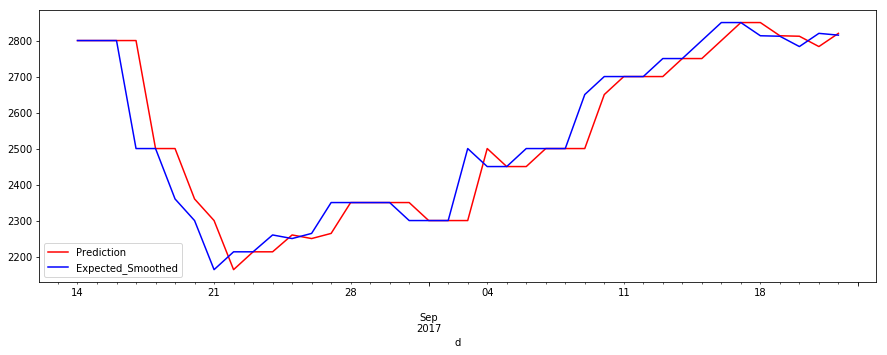

In [25]:
l = len(s_fna[0])
t = 40
w = 7
pred = runRF(s_fna[0], t, w)
plt.legend()

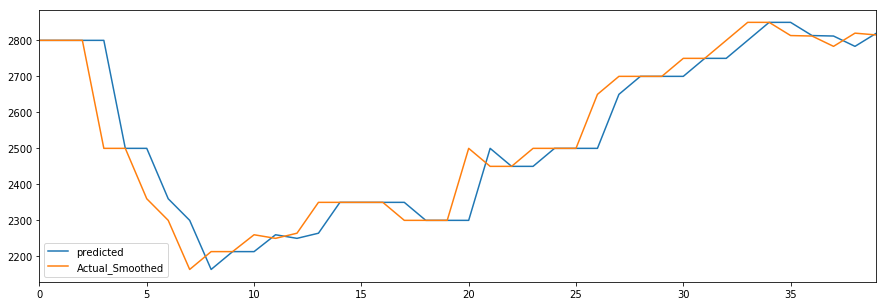

In [145]:
Series(pred).plot(label="predicted")
Series(s_fna[0].values[-t:]).plot(label="Actual_Smoothed")
plt.legend()

59
Test RMSE: 0.000, MAE:0.000, Err:0.000


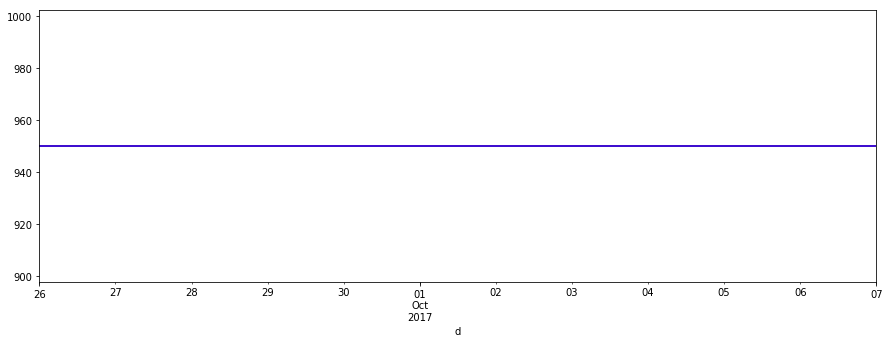

In [146]:
l = len(s_fna[1])
print l
t = 12
w = 3
pred = runRF(s_fna[1], t, w)

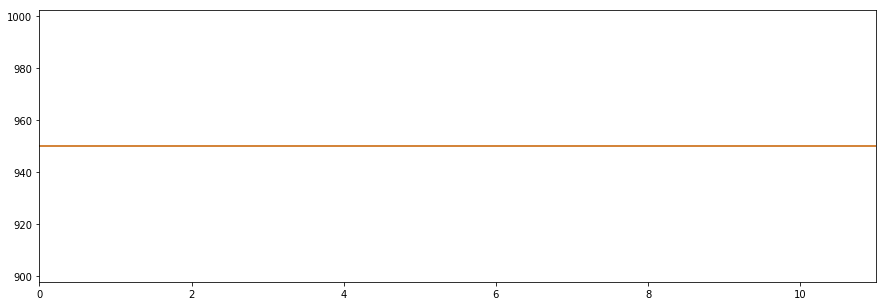

In [147]:
Series(pred).plot()
Series(s_fna[1].values[-t:]).plot()

50
Test RMSE: 12.189, MAE:4.000, Err:0.522


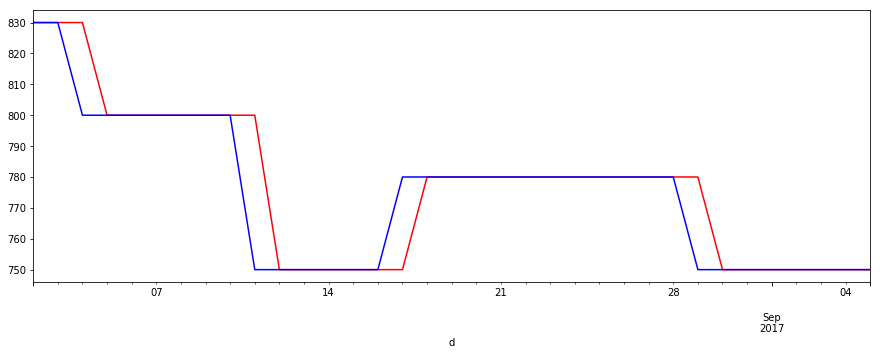

In [148]:
l = len(s_fna[2])
print l
t = 35
w = 7
pred = runRF(s_fna[2], t, w)

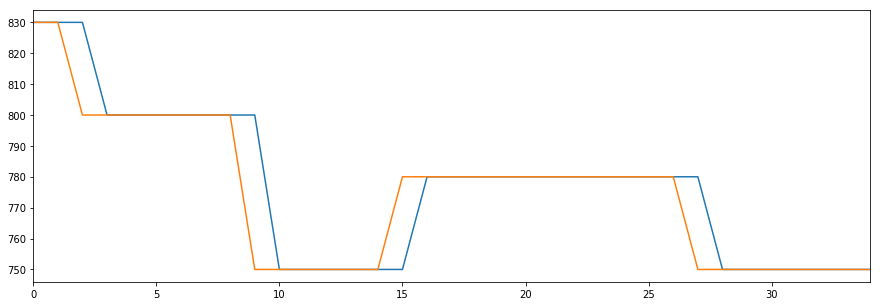

In [149]:
Series(pred).plot()
Series(s_fna[2].values[-t:]).plot()

In [150]:
s1.groupby("Customer Name").count()

,Id,From City,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Order Accepted,Order Blocked,date,ptr,d
Customer Name,,,,,,,,,,,,,,,,,,,,
Balwinder,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
Deepak Jha,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
Deepak jha,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,0,21,21,21
Jai Sai Coal Traders,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,0,43,43,43
Mahalaxmi Sachin,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6,6
konkan agro,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,0,41,41,41
rajnish,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1


In [151]:
ka=s1[s1['Customer Name']=='konkan agro']
ap=s1[s1['Customer Name']=='Anil Pichi Srinagar coal']
bw=s1[s1['Customer Name']=='Balwinder']
bw2=s1[s1['Customer Name']=='balwindar']
cs = [ka, ap, bw, bw2]

In [ ]:
# lets try to run some models now -- FOR PTR
# Let's resample series into 1day bucket and filling missing values by mean
s_fna = [x.resample("1d").mean().fillna(method="ffill") for x in sp]
s_len = [len(x) for x in s]
s_len

In [ ]:
l = len(s_fna[0])
t = 40
w = 7
pred = runRF(s_fna[0], t, w)


In [ ]:
Series(pred).plot()
Series(s_fna[0].values[-t:]).plot()

In [ ]:
# Let's Try out Anjar-Agra for Freight Amount prediction
s4.count()

In [ ]:
x = s4
s4t = Series(x['Freight Amount'].values, index=x['d'])
s4t.plot()

In [ ]:
s4_1d_fna = s4t.resample("1d").mean().fillna(method="ffill")
s4_1d_fna.plot()

In [ ]:
l = len(s4_1d_fna)
print l
t = 40
w = 7
pred = runRF(s4_1d_fna, t, w)

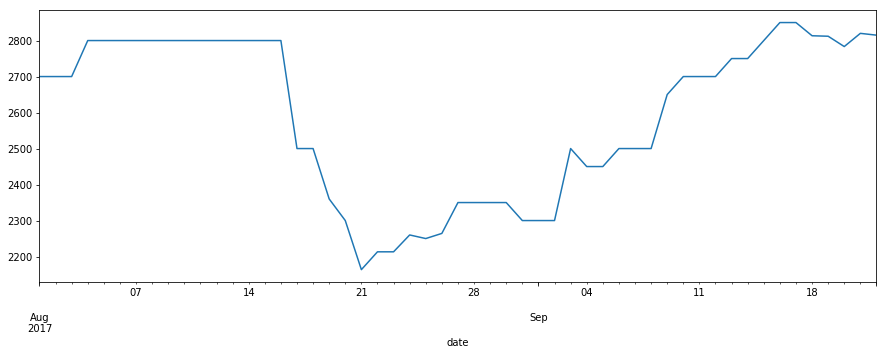

In [157]:
s=s1[s1['date']>"06/01/2017"]
series = Series(s['Per Ton Rate'].values, index=s['date'])
series.sort_index()
series.resample("1d").mean().fillna(method="ffill").plot()

In [161]:
s1 = kpi[(kpi['From Sublocation']=='Tuna') & (kpi['To Sublocation']=='Pathankot') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
s1.sort_values("date")

,Id,Customer Name,From City,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Order Accepted,Order Blocked,date,ptr,d
7012,339146,Balwinder,Anjar,Pathankot,1600313.0,Tuna,Pathankot,77922.0,30 MT,Anjar-Tuna,Pathankot-Pathankot,Mundra - Kandla cluster,28.86,2700.0,Coal,77922.0,01-Aug-2017 12:04 PM,NaN,2017-08-01 12:04:00,1.687170,2017-08-01 12:04:05.000480
5538,341150,Balwinder,Anjar,Pathankot,1600310.0,Tuna,Pathankot,84000.0,30 MT,Anjar-Tuna,Pathankot-Pathankot,Mundra - Kandla cluster,30.00,2800.0,Coal,84000.0,04-Aug-2017 04:17 PM,NaN,2017-08-04 16:17:00,1.749661,2017-08-04 16:17:07.000238
7019,341151,Balwinder,Anjar,Pathankot,1600310.0,Tuna,Pathankot,84000.0,30 MT,Anjar-Tuna,Pathankot-Pathankot,Mundra - Kandla cluster,30.00,2800.0,Coal,84000.0,04-Aug-2017 04:18 PM,NaN,2017-08-04 16:18:00,1.749661,2017-08-04 16:18:10.000800
11927,348880,konkan agro,Anjar,Pathankot,1600310.0,Tuna,Pathankot,73825.0,30 MT,Anjar-Tuna,Pathankot,Mundra - Kandla cluster,29.53,2500.0,Coal,73825.0,17-Aug-2017 10:17 AM,NaN,2017-08-17 10:17:00,1.562197,2017-08-17 10:17:06.000741
12069,348893,konkan agro,Anjar,Pathankot,1600310.0,Tuna,Pathankot,73425.0,30 MT,Anjar-Tuna,Pathankot,Mundra - Kandla cluster,29.37,2500.0,Coal,73425.0,17-Aug-2017 10:37 AM,NaN,2017-08-17 10:37:00,1.562197,2017-08-17 10:37:06.000681
3456,348894,konkan agro,Anjar,Pathankot,1600310.0,Tuna,Pathankot,61800.0,30 MT,Anjar-Tuna,Pathankot,Mundra - Kandla cluster,24.72,2500.0,Coal,61800.0,17-Aug-2017 10:38 AM,NaN,2017-08-17 10:38:00,1.562197,2017-08-17 10:38:12.000052
7985,348898,konkan agro,Anjar,Pathankot,1600310.0,Tuna,Pathankot,74250.0,30 MT,Anjar-Tuna,Pathankot,Mundra - Kandla cluster,29.70,2500.0,Coal,74250.0,17-Aug-2017 10:43 AM,NaN,2017-08-17 10:43:00,1.562197,2017-08-17 10:43:02.000327
11635,349504,konkan agro,Anjar,Pathankot,1600310.0,Tuna,Pathankot,72575.0,30 MT,Anjar-Tuna,Pathankot,Mundra - Kandla cluster,29.03,2500.0,Coal,72575.0,18-Aug-2017 01:27 AM,NaN,2017-08-18 01:27:00,1.562197,2017-08-18 01:27:04.000043
3523,350405,Deepak jha,Anjar,Pathankot,1600309.0,Tuna,Pathankot,83800.0,30 MT,Anjar-Tuna,Pathankot-Pathankot,Mundra - Kandla cluster,35.66,2350.0,Coal,83801.0,19-Aug-2017 09:55 AM,NaN,2017-08-19 09:55:00,1.468466,2017-08-19 09:55:06.000223
5760,350423,Deepak jha,Anjar,Pathankot,1600309.0,Tuna,Pathankot,82273.0,30 MT,Anjar-Tuna,Pathankot-Pathankot,Mundra - Kandla cluster,35.01,2350.0,Coal,82273.5,19-Aug-2017 10:13 AM,NaN,2017-08-19 10:13:00,1.468466,2017-08-19 10:13:13.000578


In [162]:
s1 = kpi[(kpi['From Sublocation']=='Kandla') & (kpi['To Sublocation']=='Pathankot') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
s1.sort_values("date")

,Id,Customer Name,From City,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Order Accepted,Order Blocked,date,ptr,d
6728,329819,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,78288.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,32.62,2400.0,Coal,78288.0,15-Jul-2017 04:57 PM,NaN,2017-07-15 16:57:00,1.680865,2017-07-15 16:57:01.000443
5320,329820,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,78672.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,32.78,2400.0,Coal,78672.0,15-Jul-2017 04:58 PM,NaN,2017-07-15 16:58:00,1.680865,2017-07-15 16:58:04.000906
6730,329946,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,77978.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,32.09,2430.0,Coal,77978.7,15-Jul-2017 07:00 PM,NaN,2017-07-15 19:00:00,1.701876,2017-07-15 19:00:12.000141
3244,330089,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,68952.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,28.73,2400.0,Coal,68952.0,16-Jul-2017 12:46 PM,NaN,2017-07-16 12:46:00,1.680865,2017-07-16 12:46:12.000145
9650,330090,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,69384.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,28.91,2400.0,Coal,69384.0,16-Jul-2017 12:47 PM,NaN,2017-07-16 12:47:00,1.680865,2017-07-16 12:47:15.000079
11974,331271,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,70752.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,29.48,2400.0,Coal,70752.0,18-Jul-2017 04:12 PM,NaN,2017-07-18 16:12:00,1.680865,2017-07-18 16:12:06.000437
3184,331322,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,69816.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,29.09,2400.0,Coal,69816.0,18-Jul-2017 05:03 PM,NaN,2017-07-18 17:03:00,1.680865,2017-07-18 17:03:09.000805
7029,331457,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,72000.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,30.00,2400.0,Coal,72000.0,18-Jul-2017 07:39 PM,NaN,2017-07-18 19:39:00,1.680865,2017-07-18 19:39:09.000227
9664,331823,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,83568.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,34.82,2400.0,Coal,83568.0,19-Jul-2017 12:19 PM,NaN,2017-07-19 12:19:00,1.680865,2017-07-19 12:19:07.000837
9670,333043,balwindar,Anjar,Pathankot,1427836.0,Kandla,Pathankot,68040.0,30 MT,Anjar-Kandla,Pathankot-Pathankot,Mundra - Kandla cluster,28.35,2400.0,Coal,68040.0,21-Jul-2017 10:45 AM,NaN,2017-07-21 10:45:00,1.680865,2017-07-21 10:45:04.000095
